# Imports

In [1]:
config = {
    'GRANDE': {
        'split_index_activation': 'entmax',  
        'normalize_index_array': False,
        'split_decision_activation': 'softsign', # sigmoid | softsign
        
        'depth': 6,
        'n_estimators': 1024,
                
        'learning_rate_weights': 0.01,
        'learning_rate_index': 0.01,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.01,   

        'fine_tune': False,
        'cosine_decay_steps': 0,        
        
        'reduce_lr': False,
        'reduce_lr_each_eval_nums': 10,
        'reduce_lr_fraction': 0.2,
        
        'dropout': 0,#0.25,
        
        'selected_variables': 0.8, #int number or float fraction
        'data_subset_fraction': 1.0,
        'bootstrap': False,
                
        'initializer': 'RandomNormal', 
        
        'optimizer': 'SWA', 
        
        'epochs': 10_000,
        'batch_size': 64,#512
        'drop_remainder': True,
        
        
        'loss': 'focal_crossentropy', 
        'focalLossGamma': 2.0,
        
        'transformation_type': 'mean', #for regression; mean log       
        
        'polyLoss': False,
        'polyLossEpsilon': 2.0,
        
        'weight_activation_st': 'softmax',
        'estimator_leaf_weights': True,

        'modify_grads': False,
        
        'logit_weights': True,
        #'weight_freeze_steps': 0,
        'warmup_steps': 0,
        
        'restarts': 0,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 25,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 1e-3,
        
        'class_weights': True,
        'model_seed': 42,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'quantile', #'min-max'
        'encoding_type': 'LOO', #GLMM
        'one_hot_encode_threshold': 10,
        'quantile_noise': 1e-3,

        'XGBoostEncoding': False,
        'CatBoostEncoding': True,
    },

    'computation': {
        'random_seed': 42,
        'cv_num_eval': 1,
        'subset_size': None, # medium: 10_000, large: 50_000, keep normal size: None
        
        'use_best_hpo_result': False,# True,
        'hpo_path': '_DEFAULT',
        
        'force_depth': False,
        'force_dropout': False,
        'force_class_weights': False,
        'force_restart': True,
        
        'use_gpu': True,
        'gpu_numbers': '7',
        
        'parallel_jobs_cv': 1,
        'jobs_per_gpu': 1,
                
        'search_iterations': 60,
        'cv_num_hpo': 2,     
        'report_test_performance': False,
        
        'metrics_class': ['f1', 'balanced_accuracy', 'roc_auc'],
        'metrics_reg': ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
        
        'eval_metric_class': ['f1', 'balanced_accuracy', 'roc_auc'],
        'eval_metric_reg': ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],

        'max_hours': 2.0,        
    },
    
    'benchmarks': {          
        'CART': True,
        'RandomForest': False,
        
        'XGB': True,
        'CatBoost': True,
        'NODE': True,
    }
}

In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:512"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"

import logging
logging.getLogger("ray").setLevel(logging.ERROR)
logging.getLogger("worker").setLevel(logging.ERROR)

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K

import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GRANDE import *
from utilities.GRANDE import *

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

import joblib
import ray
from ray.util.joblib import register_ray
register_ray()
from ray.autoscaler.sdk import request_resources
ray.init()

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results" + config['computation']['hpo_path'] + "/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results' + config['computation']['hpo_path'] + '/depth' + str(config['GRANDE']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)     

from anchor import anchor_tabular

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

WARNING! The apex is not installed so fp16 is not available.


2023-09-27 10:23:21,685	INFO worker.py:1621 -- Started a local Ray instance.


2023-09-27--08-23-26506545


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))
config['computation']['number_of_gpus'] = len(tf.config.experimental.list_physical_devices('GPU'))

config['computation']['n_jobs'] = config['computation']['jobs_per_gpu']*config['computation']['parallel_jobs_cv']

Num GPUs Available:  1
Num XLA-GPUs Available:  1


# Evaluation

In [4]:
identifier = 'BIN:CC18_PhishingWebsites'

dataset_dict_list, config_training, metrics = prepare_training(identifier = identifier, config = config)
dataset_dict = dataset_dict_list[0]

In [5]:
model_dict = {}

verbosity = 1

In [6]:
import sidetable
pd.DataFrame(dataset_dict['y_train']).stb.freq([dataset_dict['y_train'].name])

,class,count,percent,cumulative_count,cumulative_percent
0,1.0,4433,55.697952,4433,55.697952
1,0.0,3526,44.302048,7959,100.000000


In [7]:
dataset_dict['X_train_raw'].head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
7702,1,2,0,0,1,0,0,0,0,0,0,0,1,0,2,2,1,1,0,0,0,0,0,0,1,1,0,0,1,1
6719,0,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,1,0,0,1,1
5740,0,2,0,1,1,0,2,2,1,1,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,1
4249,1,2,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1
9116,1,2,0,0,1,0,2,1,0,0,0,1,0,2,2,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1


In [8]:
dataset_dict['X_train'].head()

,having_IP_Address,URL_Length_1,URL_Length_2,URL_Length_3,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain_1,having_Sub_Domain_2,having_Sub_Domain_3,SSLfinal_State_1,SSLfinal_State_2,SSLfinal_State_3,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor_1,URL_of_Anchor_2,URL_of_Anchor_3,Links_in_tags_1,Links_in_tags_2,Links_in_tags_3,SFH_1,SFH_2,SFH_3,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic_1,web_traffic_2,web_traffic_3,Page_Rank,Google_Index,Links_pointing_to_page_1,Links_pointing_to_page_2,Links_pointing_to_page_3,Statistical_report
7702,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,-0.422452,-0.467106,0.987373,-0.801837,-0.131176,-0.422680,0.214133,0.156268,-1.388784,-0.835152,1.019565,-0.636785,-0.283500,-0.297145,-0.448638,0.826999,-1.193845,-0.209744,1.812341,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,0.404420,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
6719,-0.962696,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,-0.422452,-0.467106,0.987373,-0.801837,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,1.019565,-0.636785,-0.283500,-0.297145,0.935549,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
5740,-0.962696,-0.218777,-0.007312,0.269907,0.145191,-1.466935,0.160372,-0.167323,-0.383116,-0.422452,0.896486,-0.432204,-0.801837,1.632389,0.984662,-1.313669,-1.507077,0.218370,-0.835152,1.019565,-0.636785,-0.283500,1.148474,-0.448638,-0.504574,0.282882,-0.209744,-0.074744,-1.356746,0.188344,1.561184,0.141386,0.054924,-1.300686,0.105146,-0.694739,0.404420,1.159972,-0.319219,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
4249,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,-0.422452,-0.467106,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,-0.835152,-0.379589,0.691141,-0.283500,-0.297145,0.935549,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,-1.016545,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
9116,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,-0.422452,0.896486,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,-0.379589,-0.636785,1.249007,-0.297145,-0.448638,0.826999,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,1.159972,-0.319219,-0.722676,-0.326079,0.178134,0.837063,-0.762095,-0.055838,0.193865


In [9]:
dataset_dict['X_train'].describe()

,having_IP_Address,URL_Length_1,URL_Length_2,URL_Length_3,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain_1,having_Sub_Domain_2,having_Sub_Domain_3,SSLfinal_State_1,SSLfinal_State_2,SSLfinal_State_3,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor_1,URL_of_Anchor_2,URL_of_Anchor_3,Links_in_tags_1,Links_in_tags_2,Links_in_tags_3,SFH_1,SFH_2,SFH_3,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic_1,web_traffic_2,web_traffic_3,Page_Rank,Google_Index,Links_pointing_to_page_1,Links_pointing_to_page_2,Links_pointing_to_page_3,Statistical_report
count,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000
mean,-0.050230,0.059896,0.022685,-0.029789,-0.074545,-0.052530,-0.057702,0.053749,0.049982,0.035785,0.031456,0.030286,-0.020231,0.052071,0.040068,-0.064975,-0.064424,-0.045551,-0.031206,0.038804,-0.001937,0.058084,0.055768,0.041801,0.030130,-0.062968,0.057244,0.057795,-0.049938,-0.056633,0.048010,-0.060905,-0.033418,-0.042644,-0.056273,0.003473,-0.043704,0.042854,0.035444,-0.005312,0.044987,-0.054141,0.024879,-0.006878,0.045104,-0.038718
std,0.662845,0.601398,0.274397,0.621680,0.562460,0.592493,0.560041,0.565261,0.653719,0.653994,0.656753,0.665356,0.678497,0.538169,0.661184,0.590394,0.564290,0.595443,0.667236,0.640620,0.663366,0.637849,0.621031,0.662106,0.652796,0.625430,0.602913,0.482261,0.608493,0.586336,0.548429,0.554486,0.422125,0.611273,0.512647,0.661247,0.660309,0.628635,0.649793,0.675628,0.632520,0.575804,0.654782,0.675128,0.438833,0.582045
min,-0.962696,-0.218777,-0.007312,-1.319221,-1.514092,-1.466935,-1.495778,-0.167323,-0.383116,-0.422452,-0.467106,-0.432204,-0.801837,-0.131176,-0.422680,-1.313669,-1.507077,-1.388784,-0.835152,-0.379589,-0.636785,-0.283500,-0.297145,-0.448638,-0.504574,-1.193845,-0.209744,-0.074744,-1.356746,-1.459813,-0.150736,-1.580575,-2.050205,-1.300686,-1.684176,-0.694739,-1.016545,-0.310853,-0.319219,-0.722676,-0.326079,-1.481364,-0.502940,-0.762095,-0.055838,-1.495120
25%,-0.962696,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,-0.422452,-0.467106,-0.432204,-0.801837,-0.131176,-0.422680,0.214133,0.156268,0.218370,-0.835152,-0.379589,-0.636785,-0.283500,-0.297145,-0.448638,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,-1.016545,-0.310853,-0.319219,-0.722676,-0.326079,0.178134,-0.502940,-0.762095,-0.055838,0.193865
50%,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,-0.422452,-0.467106,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,-0.379589,-0.636785,-0.283500,-0.297145,-0.448638,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,-0.310853,-0.319219,0.630927,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
75%,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,0.969044,0.896486,0.987373,0.568685,-0.131176,0.984662,0.214133,0.156268,0.218370,0.522498,1.019565,0.691141,-0.283500,-0.297145,0.935549,0.826999,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,-0.310853,-0.319219,0.630927,1.123044,0.178134,0.837063,0.596579,-0.055838,0.193865
max,0.431223,1.357597,2.532473,0.269907,0.145191,0.195633,0.160372,1.498884,1.036582,0.969044,0.896486,0.987

In [10]:
dataset_dict['X_train'].shape

(7959, 46)

In [11]:
if config_training['computation']['use_best_hpo_result']:
    try:
        hpo_results = read_best_hpo_result_from_csv_benchmark(identifier, 
                                                              model_identifier='GRANDE', 
                                                              config=config_training, 
                                                              return_best_only=True, 
                                                              ascending=False)      

        best_params = hpo_results['model']

        try:
            best_params['dense_layer_identifier'] = string_to_list(best_params['dense_layer_identifier'])
        except:
            pass

        try:
            best_params['num_layers'] = int(best_params['num_layers'])
        except:
            pass

        try:
            best_params['depth'] = int(best_params['depth'])
        except:
            pass            
        
        print('Loaded Parameters GRANDE for ' + identifier + ' with Score ' + str(hpo_results['cv_score']))
        print('Best Params:')
        display(best_params)

        for model_param_key, model_param_value in best_params.items():
            if model_param_key == 'depth' and config_training['computation']['force_depth']:
                if verbosity > 0:
                    print('Setting depth to ' + str(config_training['GRANDE'][model_param_key]))
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]    
            elif model_param_key == 'dropout' and config_training['computation']['force_dropout']:
                if verbosity > 0:
                    print('Setting dropout to ' + str(config_training['GRANDE'][model_param_key]))
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]     
            elif model_param_key == 'restarts' and config_training['computation']['force_restart']:
                if verbosity > 0:
                    print('Setting restarts to ' + str(config_training['GRANDE'][model_param_key]))
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]                             
            #elif model_param_key == 'restart_type' and config_training['computation']['force_restart']:
            #    if verbosity > 0:
            #        print('Setting restart_type to ' + str(config_training['GRANDE'][model_param_key]))
            #    config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]    
            elif model_param_key == 'steps':
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]    
            elif model_param_key == 'early_stopping_eval_nums':
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]    
            elif model_param_key == 'early_stopping_type':
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]                            
            elif model_param_key == 'batch_size':
                config_training['GRANDE'][model_param_key] = config_training['GRANDE'][model_param_key]                           
            else:
                config_training['GRANDE'][model_param_key] = model_param_value          

    except FileNotFoundError:
        print('No Best Parameters GRANDE for ' + identifier)
    

In [12]:
dataset_dict['X_train'].head()

,having_IP_Address,URL_Length_1,URL_Length_2,URL_Length_3,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain_1,having_Sub_Domain_2,having_Sub_Domain_3,SSLfinal_State_1,SSLfinal_State_2,SSLfinal_State_3,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor_1,URL_of_Anchor_2,URL_of_Anchor_3,Links_in_tags_1,Links_in_tags_2,Links_in_tags_3,SFH_1,SFH_2,SFH_3,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic_1,web_traffic_2,web_traffic_3,Page_Rank,Google_Index,Links_pointing_to_page_1,Links_pointing_to_page_2,Links_pointing_to_page_3,Statistical_report
7702,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,-0.422452,-0.467106,0.987373,-0.801837,-0.131176,-0.422680,0.214133,0.156268,-1.388784,-0.835152,1.019565,-0.636785,-0.283500,-0.297145,-0.448638,0.826999,-1.193845,-0.209744,1.812341,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,0.404420,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
6719,-0.962696,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,-0.422452,-0.467106,0.987373,-0.801837,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,1.019565,-0.636785,-0.283500,-0.297145,0.935549,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
5740,-0.962696,-0.218777,-0.007312,0.269907,0.145191,-1.466935,0.160372,-0.167323,-0.383116,-0.422452,0.896486,-0.432204,-0.801837,1.632389,0.984662,-1.313669,-1.507077,0.218370,-0.835152,1.019565,-0.636785,-0.283500,1.148474,-0.448638,-0.504574,0.282882,-0.209744,-0.074744,-1.356746,0.188344,1.561184,0.141386,0.054924,-1.300686,0.105146,-0.694739,0.404420,1.159972,-0.319219,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
4249,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,1.036582,-0.422452,-0.467106,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,-0.835152,-0.379589,0.691141,-0.283500,-0.297145,0.935549,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,-1.016545,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.502940,0.596579,-0.055838,0.193865
9116,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,-0.422452,0.896486,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,-0.379589,-0.636785,1.249007,-0.297145,-0.448638,0.826999,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,1.159972,-0.319219,-0.722676,-0.326079,0.178134,0.837063,-0.762095,-0.055838,0.193865


In [13]:
dataset_dict['X_valid'].head()

,having_IP_Address,URL_Length_1,URL_Length_2,URL_Length_3,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain_1,having_Sub_Domain_2,having_Sub_Domain_3,SSLfinal_State_1,SSLfinal_State_2,SSLfinal_State_3,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor_1,URL_of_Anchor_2,URL_of_Anchor_3,Links_in_tags_1,Links_in_tags_2,Links_in_tags_3,SFH_1,SFH_2,SFH_3,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic_1,web_traffic_2,web_traffic_3,Page_Rank,Google_Index,Links_pointing_to_page_1,Links_pointing_to_page_2,Links_pointing_to_page_3,Statistical_report
4930,-0.962696,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,0.969044,-0.467106,-0.432204,-0.801837,1.632389,0.984662,0.214133,0.156268,0.218370,-0.835152,-0.379589,0.691141,-0.283500,-0.297145,0.935549,-0.504574,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,0.404420,-0.310853,1.225808,-0.722676,1.123044,0.178134,-0.50294,0.596579,-0.055838,-1.495120
1076,-0.962696,-0.218777,-0.007312,0.269907,-1.514092,-1.466935,0.160372,-0.167323,1.036582,-0.422452,-0.467106,-0.432204,-0.801837,1.632389,-0.422680,0.214133,0.156268,-1.388784,-0.835152,1.019565,-0.636785,-0.283500,1.148474,-0.448638,-0.504574,0.282882,-0.209744,-0.074744,-1.356746,-1.459813,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,-1.016545,1.159972,-0.319219,-0.722676,-0.326079,0.178134,-0.50294,0.596579,-0.055838,0.193865
4921,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,-0.422452,0.896486,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,-0.379589,-0.636785,1.249007,-0.297145,-0.448638,0.826999,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.50294,0.596579,-0.055838,0.193865
8462,-0.962696,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,-0.422452,0.896486,-0.432204,0.568685,-0.131176,0.984662,0.214133,0.156268,-1.388784,-0.835152,-0.379589,0.691141,-0.283500,1.148474,-0.448638,-0.504574,-1.193845,-0.209744,1.812341,-1.356746,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.404420,1.159972,-0.319219,-0.722676,-0.326079,0.178134,-0.50294,0.596579,-0.055838,0.193865
9471,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,-0.167323,-0.383116,0.969044,-0.467106,-0.432204,0.568685,-0.131176,-0.422680,0.214133,0.156268,0.218370,0.522498,-0.379589,0.691141,-0.283500,-0.297145,-0.448638,0.826999,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,-0.694739,0.404420,-0.310853,-0.319219,0.630927,-0.326079,0.178134,-0.50294,0.596579,-0.055838,0.193865


In [14]:
dataset_dict['X_train'].shape

(7959, 46)

In [15]:
verbosity = 2

number_of_classes = len(np.unique(np.concatenate([dataset_dict['y_train'].values, dataset_dict['y_valid'].values, dataset_dict['y_test'].values]))) if config_training['GRANDE']['objective'] == 'classification' else 1


In [16]:
from_logits = not config_training['GRANDE']['logit_weights']
if config_training['GRANDE']['polyLoss']:
    #print('PolyLoss Currently not implemented')
    loss_function = poly1_cross_entropy(number_of_classes, 
                                        epsilon=config_training['GRANDE']['polyLossEpsilon'], 
                                        base_loss=config_training['GRANDE']['loss'], 
                                        focalLossGamma=config_training['GRANDE']['focalLossGamma'], 
                                        no_logits=config_training['GRANDE']['logit_weights'], 
                                        objective=config_training['GRANDE']['objective'], 
                                        class_weights=config_training['GRANDE']['class_weights'],
                                        weight_dict={'class_weights': class_weight})
else:
    if config_training['GRANDE']['loss'] == 'crossentropy':

        if number_of_classes == 2:
            loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=from_logits) #tf.keras.losses.get('binary_crossentropy')
        else:
            loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits) #tf.keras.losses.get('categorical_crossentropy')
    elif config_training['GRANDE']['loss'] == 'focal_crossentropy':
        if config_training['GRANDE']['class_weights']:
            if number_of_classes == 2:
                loss_function = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.5, gamma=config_training['GRANDE']['focalLossGamma'], apply_class_balancing=True, from_logits=from_logits)
            else:
                loss_function = SparseCategoricalFocalLoss(gamma=config_training['GRANDE']['focalLossGamma'], from_logits=from_logits) #, class_weight=class_weight
        else:
            if number_of_classes == 2:
                loss_function = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.5, gamma=config_training['GRANDE']['focalLossGamma'], apply_class_balancing=False, from_logits=from_logits)
            else:
                loss_function = SparseCategoricalFocalLoss(gamma=config_training['GRANDE']['focalLossGamma'], from_logits=from_logits)                    
    else:
        if config_training['GRANDE']['objective'] == 'regression':
            loss_function = loss_function_regression(loss_name=config_training['GRANDE']['loss'], mean=np.mean(dataset_dict['y_train']), std=np.std(dataset_dict['y_train']), transformation_type=config_training['GRANDE']['transformation_type'])
        else:
            loss_function = tf.keras.losses.get(config_training['GRANDE']['loss'])  
            loss_function.from_logits = from_logits

train_data = tf.data.Dataset.from_tensor_slices((tf.dtypes.cast(tf.convert_to_tensor(dataset_dict['X_train']), tf.float32),
                                                 tf.dtypes.cast(tf.convert_to_tensor(dataset_dict['y_train']), tf.float32)))


train_data = (train_data
        .shuffle(32768)        
        .batch(batch_size=config_training['GRANDE']['batch_size'], drop_remainder=True) 
        .prefetch(AUTOTUNE)     
        
             )

valid_data = tf.data.Dataset.from_tensor_slices((tf.dtypes.cast(tf.convert_to_tensor(dataset_dict['X_valid']), tf.float32), 
                                                 tf.dtypes.cast(tf.convert_to_tensor(dataset_dict['y_valid']), tf.float32)))


valid_data = (valid_data
        .cache()
        .batch(batch_size=config_training['GRANDE']['batch_size'], drop_remainder=False)
        .prefetch(AUTOTUNE)      
             )                     

config_training['GRANDE']['number_of_classes'] = number_of_classes
config_training['GRANDE']['number_of_variables'] = dataset_dict['X_train'].shape[1]
config_training['GRANDE']['mean'] = np.mean(dataset_dict['y_train'])
config_training['GRANDE']['std'] = np.std(dataset_dict['y_train'])
config_training['GRANDE']['random_seed'] = config_training['computation']['random_seed']

model_dict['GRANDE'] = GRANDE(**config_training['GRANDE'])  


start_GRANDE = timeit.default_timer()

if True:#config_training['GRANDE']['restart_type'] == 'metric' or config_training['GRANDE']['early_stopping_type'] == 'metric': 
    if config_training['GRANDE']['objective'] == 'classification':
        metrics_GRANDE = [F1ScoreSparse(average='macro', num_classes=number_of_classes, threshold=0.5)]
    else:
        metrics_GRANDE = [R2ScoreTransform(transformation_type=config_training['GRANDE']['transformation_type'], mean=np.mean(dataset_dict['y_train']), std=np.std(dataset_dict['y_train']))]
        #metrics_GRANDE = [tfa.metrics.RSquare()]
else:
    metrics_GRANDE = []      

if config_training['GRANDE']['early_stopping_type'] == 'metric':
    monitor = 'val_' + metrics_GRANDE[0].name
else:
    monitor = 'val_loss'              

early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                  min_delta=0.001,
                                                  patience=config_training['GRANDE']['early_stopping_epochs'], 
                                                  restore_best_weights=True)
callbacks = [early_stopping]

if config_training['GRANDE']['reduce_lr']:
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=config_training['GRANDE']['reduce_lr_fraction'], patience=config_training['GRANDE']['early_stopping_epochs']//3)
    callbacks.append(reduce_lr)

if verbosity == 1:
    callbacks.append(PlotLossesKeras())
    verbosity=0

steps_per_epoch=dataset_dict['X_train'].shape[0]//config_training['GRANDE']['batch_size']


optimizer_function_dict = {
    'weights_optimizer': get_optimizer_by_name(config_training['GRANDE']['optimizer'], config_training['GRANDE']['learning_rate_weights'], config_training['GRANDE']['warmup_steps'], steps_per_epoch=steps_per_epoch, cosine_decay_steps=config_training['GRANDE']['cosine_decay_steps']),
    'index_optimizer': get_optimizer_by_name(config_training['GRANDE']['optimizer'], config_training['GRANDE']['learning_rate_index'], config_training['GRANDE']['warmup_steps'], steps_per_epoch=steps_per_epoch, cosine_decay_steps=config_training['GRANDE']['cosine_decay_steps']),
    'values_optimizer': get_optimizer_by_name(config_training['GRANDE']['optimizer'], config_training['GRANDE']['learning_rate_values'], config_training['GRANDE']['warmup_steps'], steps_per_epoch=steps_per_epoch, cosine_decay_steps=config_training['GRANDE']['cosine_decay_steps']),
    'leaf_optimizer': get_optimizer_by_name(config_training['GRANDE']['optimizer'], config_training['GRANDE']['learning_rate_leaf'], config_training['GRANDE']['warmup_steps'], steps_per_epoch=steps_per_epoch, cosine_decay_steps=config_training['GRANDE']['cosine_decay_steps']),  
                          }

model_dict['GRANDE'].weights_optimizer = optimizer_function_dict['weights_optimizer']
model_dict['GRANDE'].index_optimizer = optimizer_function_dict['index_optimizer']
model_dict['GRANDE'].values_optimizer = optimizer_function_dict['values_optimizer']
model_dict['GRANDE'].leaf_optimizer = optimizer_function_dict['leaf_optimizer']     

model_dict['GRANDE'].compile(loss=loss_function, metrics=metrics_GRANDE)
    
if config_training['GRANDE']['class_weights'] and config_training['GRANDE']['objective']=='classification':
    class_weights = calculate_class_weights(dataset_dict['y_train'])
    class_weight_dict = {}
    for i in range(number_of_classes):
        class_weight_dict[i] = class_weights[i]
else:
    class_weight_dict = None
    
history = model_dict['GRANDE'].fit(train_data,
                                  epochs=config_training['GRANDE']['epochs'], 
                                  validation_data=valid_data,#(dataset_dict['X_valid'], dataset_dict['y_valid']), 
                                  callbacks=callbacks,
                                  class_weight = class_weight_dict,
                                  verbose=verbosity
                               )   


end_GRANDE = timeit.default_timer()
runtime = end_GRANDE - start_GRANDE      

print('RUNTIME', runtime)


Epoch 1/10000
124/124 - 19s - loss: 0.0571 - f1score_sparse: 0.9258 - val_loss: 0.0335 - val_f1score_sparse: 0.9304 - 19s/epoch - 155ms/step
Epoch 2/10000
124/124 - 1s - loss: 0.0260 - f1score_sparse: 0.9410 - val_loss: 0.0215 - val_f1score_sparse: 0.9434 - 1s/epoch - 10ms/step
Epoch 3/10000
124/124 - 1s - loss: 0.0193 - f1score_sparse: 0.9533 - val_loss: 0.0183 - val_f1score_sparse: 0.9536 - 1s/epoch - 8ms/step
Epoch 4/10000
124/124 - 1s - loss: 0.0166 - f1score_sparse: 0.9580 - val_loss: 0.0165 - val_f1score_sparse: 0.9571 - 1s/epoch - 8ms/step
Epoch 5/10000
124/124 - 1s - loss: 0.0150 - f1score_sparse: 0.9610 - val_loss: 0.0149 - val_f1score_sparse: 0.9607 - 1s/epoch - 9ms/step
Epoch 6/10000
124/124 - 1s - loss: 0.0136 - f1score_sparse: 0.9635 - val_loss: 0.0139 - val_f1score_sparse: 0.9627 - 1s/epoch - 8ms/step
Epoch 7/10000
124/124 - 1s - loss: 0.0127 - f1score_sparse: 0.9649 - val_loss: 0.0133 - val_f1score_sparse: 0.9595 - 1s/epoch - 9ms/step
Epoch 8/10000
124/124 - 1s - loss: 0

In [17]:
model_dict['GRANDE'].summary()

Model: "grande"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grande_block (GRANDEBlock)  multiple                  4775936   
                                                                 
Total params: 4775936 (18.22 MB)
Trainable params: 4775936 (18.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict,  
                               config_training = config_training,
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)

Test f1 GRANDE (0) 0.967491926357195
Test roc_auc GRANDE (0) 0.9954255707156948
Test accuracy GRANDE (0) 0.9678878335594754
________________________________________________________________________________________________________


In [19]:
if config['benchmarks']['CART']:
    try:
        with timeout(60*60*config_training['computation']['max_hours'], exception=RuntimeError):

            if config_training['computation']['use_best_hpo_result']:

                if config_training['GRANDE']['objective'] == 'classification':
                    model_identifier = 'sklearn_class'
                else:
                    model_identifier = 'sklearn_reg'

                try:
                    hpo_results = read_best_hpo_result_from_csv_benchmark(identifier, 
                                                                          model_identifier=model_identifier, 
                                                                          config=config_training, 
                                                                          return_best_only=True, 
                                                                          ascending=False)
                    if verbosity > 1:
                        print('Loaded Sklearn Parameters for ' + identifier + ' with Score ' + str(hpo_results['score']))

                    params = hpo_results['model']

                    if config_training['computation']['force_depth']:
                        params['max_depth'] = config_training['GRANDE']['depth']

                except FileNotFoundError:
                    print('No Best Parameters Sklearn for ' + identifier)     
                    params = {'max_depth': config_training['GRANDE']['depth'],
                              'random_state': config_training['computation']['random_seed']}                        

            else:
                params = {'max_depth': config_training['GRANDE']['depth'],
                          'random_state': config_training['computation']['random_seed']}
            #print('CART', params)
            start = timeit.default_timer()

            if config_training['GRANDE']['objective'] == 'classification':
                 sklearn_model = DecisionTreeClassifier
            else:
                 sklearn_model = DecisionTreeRegressor                   

            model_dict['CART'] = sklearn_model()

            if 'max_leaf_nodes' in params:
                #params['max_leaf_nodes'] = int(params['max_leaf_nodes']) if int(params['max_leaf_nodes']) >= 2 else None if isinstance(params['max_leaf_nodes'], numbers.Number) else None
                params['max_leaf_nodes'] = None if not isinstance(params['max_leaf_nodes'], numbers.Number) else int(params['max_leaf_nodes']) if int(params['max_leaf_nodes']) >= 2 else None

            if 'min_impurity_decrease' in params:
                params['min_impurity_decrease'] = 0.0 if params['min_impurity_decrease'] is None else params['min_impurity_decrease']

            #params['max_depth'] = 3
            model_dict['CART'].set_params(**params)

            if config_training['GRANDE']['class_weights']:
                model_dict['CART'].fit(enforce_numpy(dataset_dict['X_train_no_valid']), 
                          enforce_numpy(dataset_dict['y_train_no_valid']),
                          #sample_weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_train_no_valid']))
                                         )  
            else:
                model_dict['CART'].fit(enforce_numpy(dataset_dict['X_train_no_valid']), 
                          enforce_numpy(dataset_dict['y_train_no_valid']))  

            end = timeit.default_timer()  
            runtime = end - start


            print('RUNTIME', runtime)
    
    except RuntimeError as e1:
        del model_dict['NodeGAM']
        config_training['benchmarks']['NodeGAM'] = False
        print('RUNTIME ERROR')
    except (MemoryError, tf.errors.ResourceExhaustedError) as e2:
        del model_dict['NodeGAM']
        config_training['benchmarks']['NodeGAM'] = False
        print('MEMORY ERROR')    


RUNTIME 0.03896516305394471


In [20]:
if config['benchmarks']['XGB']:
    try:
        with timeout(60*60*config_training['computation']['max_hours'], exception=RuntimeError):

            start = timeit.default_timer()         

            if config_training['computation']['use_best_hpo_result']:                             

                if config_training['GRANDE']['objective'] == 'classification':
                    model_identifier = 'XGB_class'
                else:
                    model_identifier = 'XGB_reg'    

                try:
                    hpo_results = read_best_hpo_result_from_csv_benchmark(identifier, 
                                                                          model_identifier=model_identifier, 
                                                                          config=config_training, 
                                                                          return_best_only=True, 
                                                                          ascending=False)

                    if verbosity > 1:
                        print('Loaded XGB Parameters for ' + identifier + ' with Score ' + str(hpo_results['score']))

                    params = hpo_results['model']

                    if config_training['computation']['force_depth']:
                        params['max_depth'] = config_training['GRANDE']['depth']

                except FileNotFoundError:
                    print('No Best Parameters XGB for ' + identifier)          
                    params = {
                             #'learning_rate': 0.1,
                             'n_estimators': 1_000,
                             'early_stopping_rounds': 20,
                             #'max_depth': config_training['GRANDE']['depth'],
                             #'min_child_weight': 1,
                             #'gamma': 0,
                             #'subsample': 1,                    
                             #'colsample_bytree': 1,
                        
                             'max_cat_threshold': 8,
                             'random_state': config_training['computation']['random_seed'],
                             'n_jobs': 1,
                             'verbosity': 0,
                             }                        

            else:

                params = {
                             'learning_rate': 0.3,
                             'n_estimators': 1_000,
                             'early_stopping_rounds': 20,                                        
                             #'max_depth': config_training['GRANDE']['depth'],
                             #'min_child_weight': 1,
                             #'gamma': 0,
                             #'subsample': 1,                    
                             #'colsample_bytree': 1,
                    
                             'max_cat_threshold': 8,
                             'random_state': config_training['computation']['random_seed'],
                             'n_jobs': 1,
                             'verbosity': 0,
                             }  

            if config_training['GRANDE']['objective'] == 'classification':
                 xgb_model = XGBClassifier
            else:
                 xgb_model = XGBRegressor     


            if config_training['preprocessing']['XGBoostEncoding']:
                feature_types = []
                for feature_index in range(dataset_dict['X_train_raw'].shape[1]):
                    if feature_index in dataset_dict['categorical_feature_indices']:
                        feature_types.append('c')
                    else:
                        feature_types.append('q')

                model_dict['XGB'] = xgb_model(enable_categorical=True, feature_types=feature_types) 
            else:
                model_dict['XGB'] = xgb_model()                                                

            params.update({'n_jobs': int(params['n_jobs'])})
            try:
                params.update({'max_depth': int(params['max_depth'])})
            except KeyError:
                pass                                 
            params.update({'n_estimators': int(params['n_estimators'])})
            params.update({'early_stopping_rounds': int(params['early_stopping_rounds'])})

            try:
                params.update({'random_state': int(params['random_state'])})
            except:
                params.update({'seed': int(params['seed'])})

            if config_training['computation']['use_gpu']:
                params.update({'tree_method': 'gpu_hist'})
            else:
                params.update({'tree_method': 'hist'})

            model_dict['XGB'].set_params(**params)

            if config_training['preprocessing']['XGBoostEncoding']:
                if config_training['GRANDE']['class_weights']:
                    model_dict['XGB'].fit(dataset_dict['X_train_raw'], 
                              dataset_dict['y_train_raw'],
                              sample_weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_train_raw'])),
                              eval_set=[(dataset_dict['X_valid_raw'], dataset_dict['y_valid_raw'])],
                              sample_weight_eval_set=[calculate_sample_weights(enforce_numpy(dataset_dict['y_valid_raw']))], 
                              #eval_metric='auc' if config_training['GRANDE']['objective'] == 'classification' else 'mae',
                              verbose=False)    
                else:
                    model_dict['XGB'].fit(dataset_dict['X_train_raw'], 
                              dataset_dict['y_train_raw'],
                              eval_set=[(dataset_dict['X_valid_raw'], dataset_dict['y_valid_raw'])],
                              #eval_metric='auc' if config_training['GRANDE']['objective'] == 'classification' else 'mae',
                              verbose=False)  
            else:
                if config_training['GRANDE']['class_weights']:
                    model_dict['XGB'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'],
                              sample_weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_train'])),
                              eval_set=[(dataset_dict['X_valid'], dataset_dict['y_valid'])],
                              sample_weight_eval_set=[calculate_sample_weights(enforce_numpy(dataset_dict['y_valid']))], 
                              #eval_metric='auc' if config_training['GRANDE']['objective'] == 'classification' else 'mae',
                              verbose=False)    
                else:
                    model_dict['XGB'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'],
                              eval_set=[(dataset_dict['X_valid'], dataset_dict['y_valid'])],
                              #eval_metric='auc' if config_training['GRANDE']['objective'] == 'classification' else 'mae',
                              verbose=False)                  


            end = timeit.default_timer()  
            runtime = end - start     


            print('RUNTIME', runtime)
    
    except RuntimeError as e1:
        del model_dict['NodeGAM']
        config_training['benchmarks']['NodeGAM'] = False
        print('RUNTIME ERROR')
    except (MemoryError, tf.errors.ResourceExhaustedError) as e2:
        del model_dict['NodeGAM']
        config_training['benchmarks']['NodeGAM'] = False
        print('MEMORY ERROR')    


RUNTIME 1.0243699259590358


In [21]:
if config['benchmarks']['CatBoost']:
    try:
        with timeout(60*60*config_training['computation']['max_hours'], exception=RuntimeError):

            start = timeit.default_timer()         

            if config_training['computation']['use_best_hpo_result']:                             

                if config_training['GRANDE']['objective'] == 'classification':
                    model_identifier = 'CatBoost_class'
                else:
                    model_identifier = 'CatBoost_reg'    

                try:
                    hpo_results = read_best_hpo_result_from_csv_benchmark(identifier, 
                                                                          model_identifier=model_identifier, 
                                                                          config=config_training, 
                                                                          return_best_only=True, 
                                                                          ascending=False)

                    if verbosity > 1:
                        print('Loaded CatBoost Parameters for ' + identifier + ' with Score ' + str(hpo_results['score']))

                    params = hpo_results['model']

                    if config_training['computation']['force_depth']:
                        params['max_depth'] = config_training['GRANDE']['depth']

                except FileNotFoundError:
                    print('No Best Parameters CatBoost for ' + identifier)          
                    params = {
                 'n_estimators': 1_000,
                 'early_stopping_rounds': 20,
                 'random_seed': config_training['computation']['random_seed'],
                 'verbose': 0,    
                 'boosting_type': 'Plain',
                 #'one_hot_max_size': 256, 
                 #'leaf_estimation_iterations': 1,  
                 #'border_count': 32,                                        
                             }              

            else:
                params = {
                 'n_estimators': 1_000,
                 'early_stopping_rounds': 20,
                 'random_seed': config_training['computation']['random_seed'],
                 'verbose': 0,    
                 'boosting_type': 'Plain',
                 #'one_hot_max_size': 256, 
                 #'leaf_estimation_iterations': 1,  
                 #'border_count': 32,                                        
                         }                                                            

            if config_training['preprocessing']['CatBoostEncoding']:
                if config_training['GRANDE']['objective'] == 'classification':
                    if config_training['GRANDE']['class_weights']:
                        catboost_model = CatBoostClassifier
                        train_data = Pool(
                                data=enforce_numpy(dataset_dict['X_train_raw']),
                                label=enforce_numpy(dataset_dict['y_train_raw']),
                                cat_features=dataset_dict['categorical_feature_indices'],
                                weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_train_raw']))
                            )

                        eval_data = Pool(
                                data=enforce_numpy(dataset_dict['X_valid_raw']),
                                label=enforce_numpy(dataset_dict['y_valid_raw']),
                                cat_features=dataset_dict['categorical_feature_indices'],
                                weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_valid_raw']))
                            )      
                    else:
                        catboost_model = CatBoostClassifier
                        train_data = Pool(
                                data=enforce_numpy(dataset_dict['X_train_raw']),
                                label=enforce_numpy(dataset_dict['y_train_raw']),
                                cat_features=dataset_dict['categorical_feature_indices'],
                            )

                        eval_data = Pool(
                                data=enforce_numpy(dataset_dict['X_valid_raw']),
                                label=enforce_numpy(dataset_dict['y_valid_raw']),
                                cat_features=dataset_dict['categorical_feature_indices'],
                            )                                              

                else:
                    catboost_model = CatBoostRegressor 
                    train_data = Pool(
                            data=enforce_numpy(dataset_dict['X_train_raw']),
                            label=enforce_numpy(dataset_dict['y_train_raw']),
                            cat_features=dataset_dict['categorical_feature_indices'],
                        )

                    eval_data = Pool(
                            data=enforce_numpy(dataset_dict['X_valid_raw']),
                            label=enforce_numpy(dataset_dict['y_valid_raw']),
                            cat_features=dataset_dict['categorical_feature_indices'],
                        )                                       
            else:
                if config_training['GRANDE']['objective'] == 'classification':
                    if config_training['GRANDE']['class_weights']:
                        catboost_model = CatBoostClassifier
                        train_data = Pool(
                                data=enforce_numpy(dataset_dict['X_train']),
                                label=enforce_numpy(dataset_dict['y_train']),
                                cat_features=None,
                                weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_train']))
                            )

                        eval_data = Pool(
                                data=enforce_numpy(dataset_dict['X_valid']),
                                label=enforce_numpy(dataset_dict['y_valid']),
                                cat_features=None,
                                weight=calculate_sample_weights(enforce_numpy(dataset_dict['y_valid']))
                            )      
                    else:
                        catboost_model = CatBoostClassifier
                        train_data = Pool(
                                data=enforce_numpy(dataset_dict['X_train']),
                                label=enforce_numpy(dataset_dict['y_train']),
                                cat_features=None,
                            )

                        eval_data = Pool(
                                data=enforce_numpy(dataset_dict['X_valid']),
                                label=enforce_numpy(dataset_dict['y_valid']),
                                cat_features=None,
                            )                                              

                else:
                    catboost_model = CatBoostRegressor 
                    train_data = Pool(
                            data=enforce_numpy(dataset_dict['X_train']),
                            label=enforce_numpy(dataset_dict['y_train']),
                            cat_features=None,
                        )

                    eval_data = Pool(
                            data=enforce_numpy(dataset_dict['X_valid']),
                            label=enforce_numpy(dataset_dict['y_valid']),
                            cat_features=None,
                        )                               

            model_dict['CatBoost'] = catboost_model()

            if config_training['computation']['use_gpu']:
                params.update({'task_type': 'GPU'})
            else:
                params.update({'task_type': 'CPU'})

            params.update({'gpu_ram_part': 0.8/config_training['computation']['n_jobs']/config_training['computation']['number_of_gpus']})
            params.update({'used_ram_limit': '16GB'})
            params.update({'thread_count': 1}) 
            params.update({'devices': '0'}) 

            model_dict['CatBoost'].set_params(**params)

            model_dict['CatBoost'].fit(X=train_data, eval_set=eval_data)



            end = timeit.default_timer()  
            runtime = end - start     


            print('RUNTIME', runtime)
    
    except RuntimeError as e1:
        del model_dict['NodeGAM']
        config_training['benchmarks']['NodeGAM'] = False
        print('RUNTIME ERROR')
    except (MemoryError, tf.errors.ResourceExhaustedError) as e2:
        del model_dict['NodeGAM']
        config_training['benchmarks']['NodeGAM'] = False
        print('MEMORY ERROR')    


RUNTIME 15.141484920168296


In [22]:
if config['benchmarks']['NODE']:
    try:
        with timeout(60*60*config_training['computation']['max_hours'], exception=RuntimeError):

            start = timeit.default_timer()         

            if config_training['computation']['use_best_hpo_result']:                             


                try:
                    hpo_results = read_best_hpo_result_from_csv_benchmark(identifier, 
                                                                          model_identifier=key,
                                                                          config=config_training, 
                                                                          return_best_only=True, 
                                                                          ascending=False)
                    if verbosity > 1:
                        print('Loaded NODE Parameters for ' + identifier + ' with Score ' + str(hpo_results['score']))

                    params = hpo_results['model']

                    if config_training['computation']['force_depth']:
                        params['tree_depth'] = config_training['GRANDE']['depth']

                except FileNotFoundError:
                    print('No Best Parameters NODE for ' + identifier)          
                    params = {
                              'num_layers': 3,
                              'total_tree_count': np.sum(config_training['GRANDE']['n_estimators']) if isinstance(config_training['GRANDE']['n_estimators'], list) else config_training['GRANDE']['n_estimators'],
                              'tree_depth': config_training['GRANDE']['depth'],
                              'tree_output_dim': 2,
                             }         

            else:
                params = {
                          'num_layers': 3,
                          'total_tree_count': np.sum(config_training['GRANDE']['n_estimators']) if isinstance(config_training['GRANDE']['n_estimators'], list) else config_training['GRANDE']['n_estimators'],
                          'tree_depth': config_training['GRANDE']['depth'],
                          'tree_output_dim': 2,
                         }       


            torch.manual_seed(config_training['computation']['random_seed'])
            random.seed(config_training['computation']['random_seed'])
            np.random.seed(config_training['computation']['random_seed'])                                     
            args = {'num_features': dataset_dict['X_train'].shape[1],
                   'objective': 'binary' if config_training['GRANDE']['objective'] == 'classification' and number_of_classes==2 else config_training['GRANDE']['objective'],#config_training['GRANDE']['objective'],
                   'num_classes': 1 if config_training['GRANDE']['objective'] == 'classification' and number_of_classes==2 else number_of_classes,
                   'use_gpu': config_training['computation']['use_gpu'],
                   'data_parallel': False,
                   'early_stopping_rounds': 20,
                   'logging_period': 100,
                   'batch_size': config_training['GRANDE']['batch_size'],
                   'val_batch_size': config_training['GRANDE']['batch_size'],
                   'epochs': 1000}                            

            args = MyDictObject(**args)
            model_dict['NODE'] = NODE(params, args)

            model_dict['NODE'].fit(X=enforce_numpy(dataset_dict['X_train'], dtype='float'),
                                  y=enforce_numpy(dataset_dict['y_train'], dtype='float'),
                                  X_val=enforce_numpy(dataset_dict['X_valid'], dtype='float'),
                                  y_val=enforce_numpy(dataset_dict['y_valid'], dtype='float'))

            end = timeit.default_timer()  
            runtime = end - start     



            print('RUNTIME', runtime)
    
    except RuntimeError as e1:
        del model_dict['NODE']
        config_training['benchmarks']['NODE'] = False
        print('RUNTIME ERROR')
    except (MemoryError, tf.errors.ResourceExhaustedError) as e2:
        del model_dict['NODE']
        config_training['benchmarks']['NODE'] = False
        print('MEMORY ERROR')    
    free_memory()

RUNTIME 353.54855979816057


# CART Decision Tree Visualization

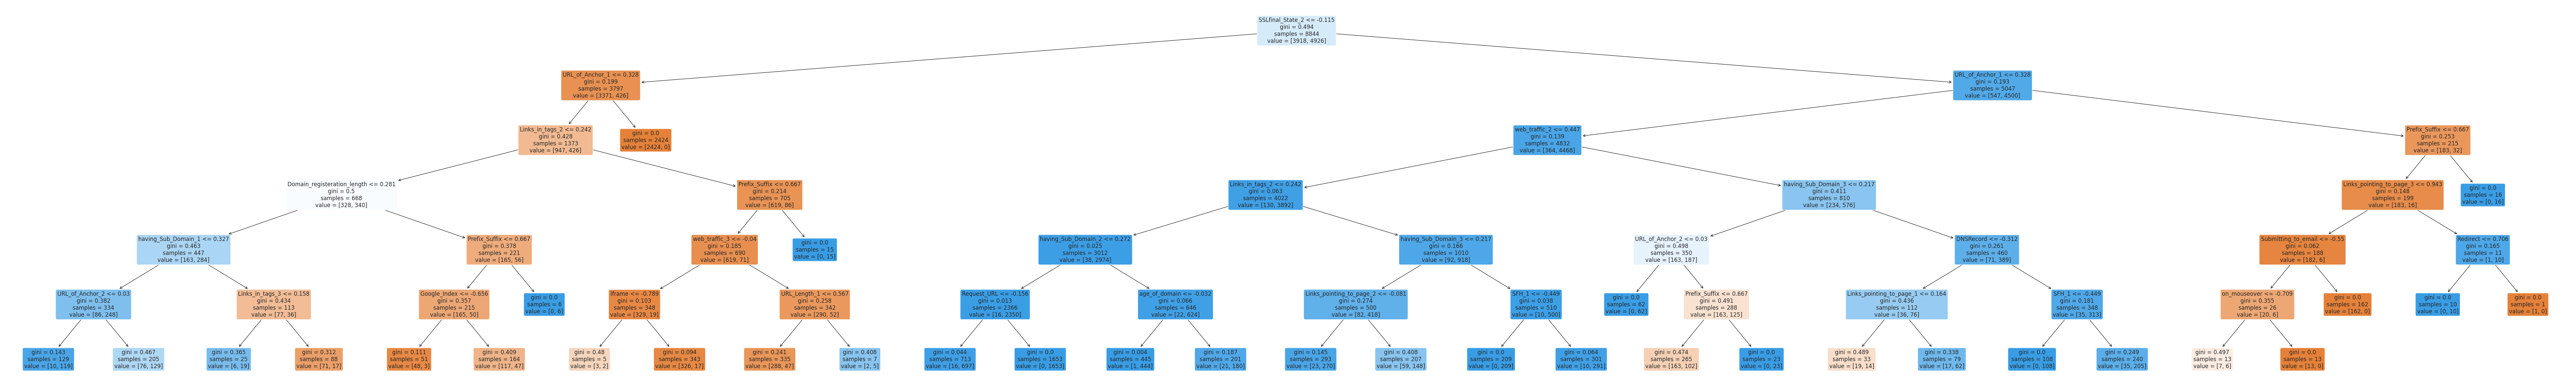

In [23]:
# Plot the tree with enhancements
plt.figure(figsize=(100, 15))  # Increase the size of the figure
plot_tree(model_dict['CART'],
          feature_names=list(dataset_dict['X_train_no_valid'].columns),
          #class_names=classes,
          filled=True,
          rounded=True,
          fontsize=12)
plt.show()

# Performance comparison with CART

In [24]:
target = pd.DataFrame(dataset_dict['y_test'], index=dataset_dict['X_test'].index)

preds_sklearn = pd.DataFrame(model_dict['CART'].predict_proba(dataset_dict['X_test'])[:,1], index=dataset_dict['X_test'].index, columns=['DT'])
preds_sklearn_round = np.round(preds_sklearn)


################################################################################################################

preds_XGB = pd.DataFrame(model_dict['XGB'].predict(dataset_dict['X_test']), index=dataset_dict['X_test'].index, columns=['XGB'])
preds_XGB_round = np.round(preds_XGB)
#display(preds_XGB)

df = pd.concat([target, preds_sklearn, preds_XGB], axis=1)
#display(df)

if False:
    df = df[(df['DT']>0.95) | (df['DT']<0.05)]
df['DT'] = np.round(df['DT'].values)
df['XGB'] = np.round(df['XGB'].values)

df_DT_correct = df[df['class']==df['DT']]
df_DT_correct_XGB_correct = df[(df['class'] == df['DT']) & (df['class'] == df['XGB'])]
df_DT_correct_XGB_incorrect = df[(df['class'] == df['DT']) & (df['class'] != df['XGB'])]
df_DT_incorrect = df[df['class']!=df['DT']]
df_DT_incorrect_XGB_correct = df[(df['class'] != df['DT']) & (df['class'] == df['XGB'])]
df_DT_incorrect_XGB_incorrect = df[(df['class'] != df['DT']) & (df['class'] != df['XGB'])]

TP = df_DT_correct_XGB_correct.shape[0]
FN = df_DT_incorrect_XGB_correct.shape[0]
FP = df_DT_correct_XGB_incorrect.shape[0]
TN = df_DT_incorrect_XGB_incorrect.shape[0]

# Calculate column totals
total_predicted_correct = TP + FP
total_predicted_incorrect = FN + TN

print("Confusion Matrix:")
print("------------------")
print(f"\t\t\t    Correct DT        Incorrect DT                 Total")
print(f"Correct XGB\t\t{TP:^18} {FN:^18}        {TP + FN:^18}")
print(f"Incorrect XGB\t\t{FP:^18} {TN:^18}        {FP + TN:^18}")

########################################################################

preds_CatBoost = pd.DataFrame(model_dict['CatBoost'].predict(dataset_dict['X_test_raw']), index=dataset_dict['X_test_raw'].index, columns=['CatBoost'])
preds_CatBoost_round = np.round(preds_CatBoost)
#display(preds_GRANDE)

df = pd.concat([target, preds_sklearn, preds_CatBoost], axis=1)
all_samples_indices = list(df.index)
#display(df)

if False:
    df = df[(df['DT']>0.9) | (df['DT']<0.1)]
df['DT'] = np.round(df['DT'].values)
df['CatBoost'] = np.round(df['CatBoost'].values)

df_DT_correct = df[df['class']==df['DT']]
easy_samples_indices = list(df_DT_correct.index)
hard_samples_indices = list(set(all_samples_indices) - set(easy_samples_indices))
df_DT_correct_CatBoost_correct = df[(df['class'] == df['DT']) & (df['class'] == df['CatBoost'])]
df_DT_correct_CatBoost_incorrect = df[(df['class'] == df['DT']) & (df['class'] != df['CatBoost'])]
df_DT_incorrect = df[df['class']!=df['DT']]
df_DT_incorrect_CatBoost_correct = df[(df['class'] != df['DT']) & (df['class'] == df['CatBoost'])]
df_DT_incorrect_CatBoost_incorrect = df[(df['class'] != df['DT']) & (df['class'] != df['CatBoost'])]

TP = df_DT_correct_CatBoost_correct.shape[0]
FN = df_DT_incorrect_CatBoost_correct.shape[0]
FP = df_DT_correct_CatBoost_incorrect.shape[0]
TN = df_DT_incorrect_CatBoost_incorrect.shape[0]

# Calculate column totals
total_predicted_correct = TP + FP
total_predicted_incorrect = FN + TN

print(f"Correct CatBoost \t{TP:^18} {FN:^18}        {TP + FN:^18}")
print(f"Incorrect CatBoost \t{FP:^18} {TN:^18}        {FP + TN:^18}")

################################################################################################################

preds_NODE = pd.DataFrame(model_dict['NODE'].predict(dataset_dict['X_test']), index=dataset_dict['X_test'].index, columns=['NODE'])
preds_NODE_round = np.round(preds_NODE)
#display(preds_NODE)

df = pd.concat([target, preds_sklearn, preds_NODE], axis=1)
#display(df)

if False:
    df = df[(df['DT']>0.95) | (df['DT']<0.05)]
df['DT'] = np.round(df['DT'].values)
df['NODE'] = np.round(df['NODE'].values)

df_DT_correct = df[df['class']==df['DT']]
df_DT_correct_NODE_correct = df[(df['class'] == df['DT']) & (df['class'] == df['NODE'])]
df_DT_correct_NODE_incorrect = df[(df['class'] == df['DT']) & (df['class'] != df['NODE'])]
df_DT_incorrect = df[df['class']!=df['DT']]
df_DT_incorrect_NODE_correct = df[(df['class'] != df['DT']) & (df['class'] == df['NODE'])]
df_DT_incorrect_NODE_incorrect = df[(df['class'] != df['DT']) & (df['class'] != df['NODE'])]

TP = df_DT_correct_NODE_correct.shape[0]
FN = df_DT_incorrect_NODE_correct.shape[0]
FP = df_DT_correct_NODE_incorrect.shape[0]
TN = df_DT_incorrect_NODE_incorrect.shape[0]

# Calculate column totals
total_predicted_correct = TP + FP
total_predicted_incorrect = FN + TN

print(f"Correct NODE\t\t{TP:^18} {FN:^18}        {TP + FN:^18}")
print(f"Incorrect NODE\t\t{FP:^18} {TN:^18}        {FP + TN:^18}")

################################################################################################################

preds_GRANDE = pd.DataFrame(model_dict['GRANDE'].predict(dataset_dict['X_test'], batch_size=64, verbose=0), index=dataset_dict['X_test'].index, columns=['GRANDE'])
preds_GRANDE_round = np.round(preds_GRANDE)

df = pd.concat([target, preds_sklearn, preds_GRANDE], axis=1)
all_samples_indices = list(df.index)
#display(df)

if False:
    df = df[(df['DT']>0.9) | (df['DT']<0.1)]
df['DT'] = np.round(df['DT'].values)
df['GRANDE'] = np.round(df['GRANDE'].values)

df_DT_correct = df[df['class']==df['DT']]
easy_samples_indices = list(df_DT_correct.index)
hard_samples_indices = list(set(all_samples_indices) - set(easy_samples_indices))
df_DT_correct_GRANDE_correct = df[(df['class'] == df['DT']) & (df['class'] == df['GRANDE'])]
df_DT_correct_GRANDE_incorrect = df[(df['class'] == df['DT']) & (df['class'] != df['GRANDE'])]
df_DT_incorrect = df[df['class']!=df['DT']]
df_DT_incorrect_GRANDE_correct = df[(df['class'] != df['DT']) & (df['class'] == df['GRANDE'])]
df_DT_incorrect_GRANDE_incorrect = df[(df['class'] != df['DT']) & (df['class'] != df['GRANDE'])]

TP = df_DT_correct_GRANDE_correct.shape[0]
FN = df_DT_incorrect_GRANDE_correct.shape[0]
FP = df_DT_correct_GRANDE_incorrect.shape[0]
TN = df_DT_incorrect_GRANDE_incorrect.shape[0]

# Calculate column totals
total_predicted_correct = TP + FP
total_predicted_incorrect = FN + TN


print(f"Correct GRANDE\t\t{TP:^18} {FN:^18}        {TP + FN:^18}")
print(f"Incorrect GRANDE\t{FP:^18} {TN:^18}        {FP + TN:^18}")
print(f"Total\t\t\t{total_predicted_correct:^18} {total_predicted_incorrect:^18}")


Confusion Matrix:
------------------
			    Correct DT        Incorrect DT                 Total
Correct XGB		       2018               115                       2133       
Incorrect XGB		        9                  69                        78        
Correct CatBoost 	       2019               105                       2124       
Incorrect CatBoost 	        8                  79                        87        
Correct NODE		       2012               112                       2124       
Incorrect NODE		        15                 72                        87        
Correct GRANDE		       2012               128                       2140       
Incorrect GRANDE	        15                 56                        71        
Total			       2027               184        


# Instance-Weights Inspection

In [25]:
#index_start = 0
#index_end = 10
X_test = dataset_dict['X_test'].values#[index_start:index_end]
y_test = dataset_dict['y_test'].values#[index_start:index_end]
X_test = tf.cast(X_test, tf.float32)

preds_list = []
instance_wise_estimator_weights_list = []

i = 0
while i*64 < X_test.shape[0]:
    X_test_batch = X_test[i*64:(i+1)*64]
    pred, instance_wise_estimator_weights = model_dict['GRANDE'].output_with_weights(X_test_batch)
    pred = pred.numpy()
    instance_wise_estimator_weights = instance_wise_estimator_weights.numpy()
    preds_list.extend(pred)
    instance_wise_estimator_weights_list.extend(instance_wise_estimator_weights)
    i += 1
#print('PRED:', pred)
preds = np.array(preds_list)
instance_wise_estimator_weights = np.array(instance_wise_estimator_weights_list)


instance_wise_estimator_weights_mean = np.mean(instance_wise_estimator_weights, axis=1)
instance_wise_estimator_weights_std = np.std(instance_wise_estimator_weights, axis=1)
instance_wise_estimator_weights_max = np.max(instance_wise_estimator_weights, axis=1)
instance_wise_estimator_weights_sum_top_3 = np.sum(top_k_elements_per_row(instance_wise_estimator_weights, 3), axis=1)
instance_wise_estimator_weights_sum_top_5 = np.sum(top_k_elements_per_row(instance_wise_estimator_weights, 5), axis=1)
instance_wise_estimator_weights_sum_top_10 = np.sum(top_k_elements_per_row(instance_wise_estimator_weights, 10), axis=1)

instance_wise_estimator_weights_df = pd.DataFrame({
    'mean': instance_wise_estimator_weights_mean,
    'std': instance_wise_estimator_weights_std,
    'max': instance_wise_estimator_weights_max,
    'sum_top_3': instance_wise_estimator_weights_sum_top_3,
    'sum_top_5': instance_wise_estimator_weights_sum_top_5,
    'sum_top_10': instance_wise_estimator_weights_sum_top_10
}, index=dataset_dict['X_test'].index)

display(instance_wise_estimator_weights_df)


,mean,std,max,sum_top_3,sum_top_5,sum_top_10
6559,0.000977,0.006964,0.146938,0.285041,0.396885,0.605009
10527,0.000977,0.020410,0.649864,0.725904,0.762534,0.812761
3312,0.000977,0.008197,0.173977,0.410333,0.532019,0.618059
4569,0.000977,0.007474,0.141100,0.318640,0.449948,0.660412
6343,0.000977,0.005080,0.112248,0.207145,0.277372,0.388419
...,...,...,...,...,...,...
7962,0.000977,0.009392,0.204263,0.470517,0.602832,0.715587
1988,0.000977,0.005268,0.080452,0.180528,0.258093,0.432787
9403,0.000977,0.029101,0.931427,0.962451,0.974853,0.987882
3174,0.000977,0.028907,0.925206,0.956023,0.968342,0.981345


In [35]:
number_of_weights = 5
weights = top_k_elements_per_row(instance_wise_estimator_weights, number_of_weights)
indices = top_k_indices_per_row(instance_wise_estimator_weights, number_of_weights)
weight_index_dataframe = pd.DataFrame(pairwise_concatenate(weights, indices), columns=flatten_list([['weight_' + str(i), 'index_' + str(i)] for i in range(number_of_weights)]), index=dataset_dict['X_test'].index)
display(weight_index_dataframe.head(20))
display(weight_index_dataframe.sort_values(by=['weight_0'], ascending=False).head(20))


,weight_0,index_0,weight_1,index_1,weight_2,index_2,weight_3,index_3,weight_4,index_4
6559,0.146938,578.0,0.078244,346.0,0.059858,727.0,0.056918,719.0,0.054926,369.0
10527,0.649864,388.0,0.052724,446.0,0.023316,841.0,0.018946,385.0,0.017684,578.0
3312,0.173977,539.0,0.128648,409.0,0.107708,304.0,0.062335,201.0,0.059350,581.0
4569,0.141100,481.0,0.095593,278.0,0.081947,165.0,0.070010,959.0,0.061297,700.0
6343,0.112248,446.0,0.050456,325.0,0.044440,488.0,0.040336,385.0,0.029891,699.0
9741,0.121728,555.0,0.095766,327.0,0.080676,539.0,0.079543,961.0,0.059656,409.0
8345,0.185170,81.0,0.094382,539.0,0.090640,93.0,0.077552,674.0,0.058431,304.0
9358,0.229859,555.0,0.116339,676.0,0.094560,188.0,0.094313,304.0,0.054582,201.0
10387,0.122784,538.0,0.078226,637.0,0.068610,38.0,0.056798,134.0,0.048375,721.0
7907,0.333205,402.0,0.056481,229.0,0.051655,729.0,0.041399,862.0,0.038799,255.0


,weight_0,index_0,weight_1,index_1,weight_2,index_2,weight_3,index_3,weight_4,index_4
10321,0.937949,252.0,0.019054,152.0,0.012187,980.0,0.006401,219.0,0.006088,984.0
4662,0.937453,252.0,0.019044,152.0,0.012181,980.0,0.006398,219.0,0.006085,984.0
9632,0.937227,252.0,0.019039,152.0,0.012178,980.0,0.006396,219.0,0.006083,984.0
7164,0.937049,252.0,0.019036,152.0,0.012176,980.0,0.006395,219.0,0.006082,984.0
10843,0.936948,252.0,0.019033,152.0,0.012174,980.0,0.006394,219.0,0.006081,984.0
10348,0.936861,252.0,0.019032,152.0,0.012173,980.0,0.006394,219.0,0.006081,984.0
2873,0.936722,252.0,0.019029,152.0,0.012171,980.0,0.006393,219.0,0.006080,984.0
9272,0.936607,252.0,0.019027,152.0,0.012170,980.0,0.006392,219.0,0.006079,984.0
5794,0.936592,252.0,0.019026,152.0,0.012170,980.0,0.006392,219.0,0.006079,984.0
6061,0.936387,252.0,0.019022,152.0,0.012167,980.0,0.006390,219.0,0.006078,984.0


Internal Nodes Pruned: 2
Leaf Nodes Pruned: 3


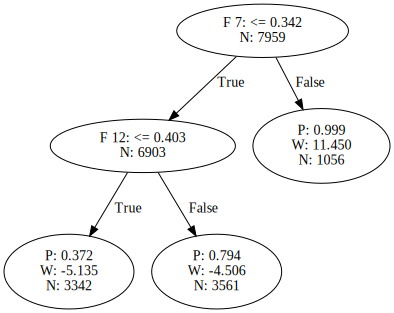

In [47]:
tree_index = 252
plot_tree_by_index(model_dict['GRANDE'], tree_index, dataset_dict['X_train'])

In [56]:
instance_index = 4662
X_test = dataset_dict['X_test'].loc[instance_index].values.reshape(1,-1)
y_test = dataset_dict['y_test'].loc[instance_index].reshape(1,-1)
X_test = tf.cast(X_test, tf.float32)

prediction, _ = model_dict['GRANDE'].output_with_weights(X_test)
print(prediction)

df = pd.DataFrame(X_test.numpy(),columns=dataset_dict['X_test'].columns)
display(df)
df = df.iloc[:,[7,12]]
df.insert(0, 'prediction', prediction)
df.insert(0, 'target', y_test)
display(df)

tf.Tensor([[0.9974965]], shape=(1, 1), dtype=float32)


,having_IP_Address,URL_Length_1,URL_Length_2,URL_Length_3,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain_1,having_Sub_Domain_2,having_Sub_Domain_3,SSLfinal_State_1,SSLfinal_State_2,SSLfinal_State_3,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor_1,URL_of_Anchor_2,URL_of_Anchor_3,Links_in_tags_1,Links_in_tags_2,Links_in_tags_3,SFH_1,SFH_2,SFH_3,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic_1,web_traffic_2,web_traffic_3,Page_Rank,Google_Index,Links_pointing_to_page_1,Links_pointing_to_page_2,Links_pointing_to_page_3,Statistical_report
0,0.431223,-0.218777,-0.007312,0.269907,0.145191,0.195633,0.160372,1.498884,-0.383116,-0.422452,0.896486,0.987373,-0.801837,-0.131176,-0.42268,0.214133,0.156268,0.21837,0.522498,-0.379589,0.691141,-0.2835,-0.297145,-0.448638,0.826999,0.282882,-0.209744,-0.074744,0.233361,0.188344,-0.150736,0.141386,0.054924,0.254331,0.105146,0.629633,0.40442,-0.310853,1.225808,-0.722676,-0.326079,0.178134,-0.50294,0.596579,-0.055838,0.193865


,target,prediction,Prefix_Suffix,SSLfinal_State_2
0,1.0,0.997496,1.498884,-0.801837


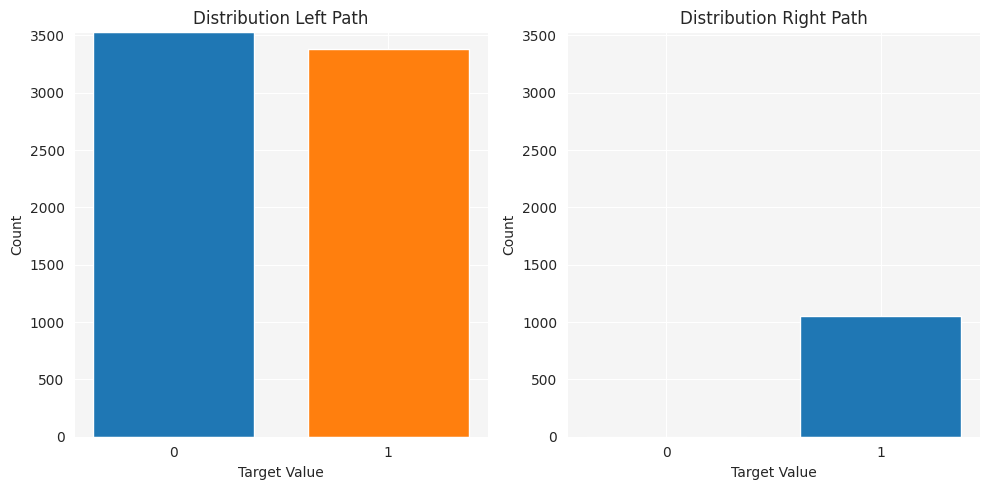

In [50]:
# Extracting the feature name at index 1
feature_index_list = [7]
feature_threshold_list = [0.324]
direction_list = ['right']
df = dataset_dict['X_train'].copy(deep=True)
df = df.assign(target=dataset_dict['y_train'].values)

# Variables
bar_width = 0.75 
plot_size = (10, 5)  

title_1 = "Distribution Left Path"  
title_2 = "Distribution Right Path"

colors = ["#1f77b4", "#ff7f0e"]

plt.rcParams['axes.facecolor'] = '#f5f5f5'  

combined_condition = True
for feature_index, feature_threshold, direction in zip(feature_index_list, feature_threshold_list, direction_list):
    if direction == 'left':
        condition = (df[df.columns[feature_index]] <= feature_threshold)
    else:
        condition = ~(df[df.columns[feature_index]] <= feature_threshold)
    combined_condition = combined_condition & condition

subset1 = df[~condition]
subset2 = df[condition]

subset1_target_counts = subset1['target'].value_counts()
subset2_target_counts = subset2['target'].value_counts()

all_unique_targets = list(set(subset1_target_counts.index) | set(subset2_target_counts.index))
for target in all_unique_targets:
    subset1_target_counts[target] = subset1_target_counts.get(target, 0)
    subset2_target_counts[target] = subset2_target_counts.get(target, 0)

max_y_val = max(subset1_target_counts.max(), subset2_target_counts.max())

fig, axes = plt.subplots(1, 2, figsize=plot_size)

axes[0].bar(subset1_target_counts.index, subset1_target_counts.values, color=colors, width=bar_width)
axes[0].set_title(title_1)
axes[0].set_xlabel("Target Value")
axes[0].set_ylabel("Count")
axes[0].set_xticks(all_unique_targets)  
axes[0].set_ylim(0, max_y_val) 
axes[0].tick_params(axis='both', which='major', labelsize=10) 

axes[1].bar(subset2_target_counts.index, subset2_target_counts.values, color=colors, width=bar_width)
axes[1].set_title(title_2)
axes[1].set_xlabel("Target Value")
axes[1].set_ylabel("Count")
axes[1].set_xticks(all_unique_targets)  
axes[1].set_ylim(0, max_y_val)  
axes[1].tick_params(axis='both', which='major', labelsize=10)  

plt.tight_layout()
plt.savefig('./data_split_distribution.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
instance_wise_estimator_weights_df_hard_samples = instance_wise_estimator_weights_df.loc[hard_samples_indices]
display(instance_wise_estimator_weights_df_hard_samples.mean())
instance_wise_estimator_weights_df_easy_samples = instance_wise_estimator_weights_df.loc[easy_samples_indices]
display(instance_wise_estimator_weights_df_easy_samples.mean())

df1 = instance_wise_estimator_weights_df_easy_samples
df2 = instance_wise_estimator_weights_df_hard_samples

# Find the global minimum and maximum for normalization
global_min_max = min(df1['max'].min(), df2['max'].min())
global_max_max = max(df1['max'].max(), df2['max'].max())

global_min_sum_top_3 = min(df1['sum_top_3'].min(), df2['sum_top_3'].min())
global_max_sum_top_3 = max(df1['sum_top_3'].max(), df2['sum_top_3'].max())

# Normalize the values
df1['max_normalized'] = (df1['max'] - global_min_max) / (global_max_max - global_min_max)
df2['max_normalized'] = (df2['max'] - global_min_max) / (global_max_max - global_min_max)

df1['sum_top_3_normalized'] = (df1['sum_top_3'] - global_min_sum_top_3) / (global_max_sum_top_3 - global_min_sum_top_3)
df2['sum_top_3_normalized'] = (df2['sum_top_3'] - global_min_sum_top_3) / (global_max_sum_top_3 - global_min_sum_top_3)

# Create scatterplot
plt.scatter(df1['max_normalized'], df1['sum_top_3_normalized'], color='blue', label='Easy Samples')
plt.scatter(df2['max_normalized'], df2['sum_top_3_normalized'], color='orange', label='Hard Samples')
plt.legend()
plt.xlabel('max_normalized')
plt.ylabel('sum_top_3_normalized')
plt.title('Scatterplot')
plt.show()


# Anchors Explanations

In [62]:
prediction, _ = model_dict['GRANDE'].output_with_weights(X_test)
print(prediction)

df = pd.DataFrame(X_test.numpy(),columns=dataset_dict['X_test'].columns)
df = df.iloc[:,[7,12]]
df.insert(0, 'prediction', prediction)
df.insert(0, 'target', y_test)
display(df)
display(instance_wise_estimator_weights_df.loc[[instance_index]])

np.random.seed(42)

# Define predict function
predict_fn = lambda x: model_dict['XGB'].predict(x)
#predict_fn = lambda x: model_dict['XGB'].predict_proba(x)[:,1]

# Create an explainer for the model
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset_dict['y_train'].unique().astype(int),
    dataset_dict['X_train'].columns,
    dataset_dict['X_train'].values,
    categorical_names={})  # Assuming no categorical variables

explanation = explainer.explain_instance(X_test.numpy()[0], predict_fn, threshold=1)

# Print the explanation
print('XGBoost')
print('Anchor: %s' % (' AND '.join(explanation.names())))
print('Precision: %.2f' % explanation.precision())
print('Coverage: %.2f' % explanation.coverage())
print('____________________________________________________________________________')

np.random.seed(42)

X_test_raw = dataset_dict['X_test_raw'].loc[instance_index].values.reshape(1,-1)
#y_test_raw = dataset_dict['y_test_raw'].loc[index:index+1].values
#X_test_raw = tf.cast(X_test_raw, tf.float32)

# Define predict function
predict_fn = lambda x: model_dict['CatBoost'].predict(x)
#predict_fn = lambda x: model_dict['XGB'].predict_proba(x)[:,1]

# Create an explainer for the model
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset_dict['y_train'].unique().astype(int),
    dataset_dict['X_train_raw'].columns,
    dataset_dict['X_train_raw'].values,
    categorical_names={})  # Assuming no categorical variables

explanation = explainer.explain_instance(X_test_raw[0], predict_fn, threshold=1)

# Print the explanation
print('CatBoost')
print('Anchor: %s' % (' AND '.join(explanation.names())))
print('Precision: %.2f' % explanation.precision())
print('Coverage: %.2f' % explanation.coverage())
print('____________________________________________________________________________')


np.random.seed(42)

# Define predict function
predict_fn = lambda x: np.round(model_dict['NODE'].predict_proba(x)[:,1])
#predict_fn = lambda x: model_dict['XGB'].predict_proba(x)[:,1]

# Create an explainer for the model
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset_dict['y_train'].unique().astype(int),
    dataset_dict['X_train'].columns,
    dataset_dict['X_train'].values,
    categorical_names={})  # Assuming no categorical variables

explanation = explainer.explain_instance(X_test.numpy()[0], predict_fn, threshold=1)

# Print the explanation
print('NODE')
print('Anchor: %s' % (' AND '.join(explanation.names())))
print('Precision: %.2f' % explanation.precision())
print('Coverage: %.2f' % explanation.coverage())
print('____________________________________________________________________________')


np.random.seed(42)

# Define predict function
predict_fn = lambda x: np.round(model_dict['GRANDE'].predict(x, 64, 0)[:,0])
#predict_fn = lambda x: model_dict['XGB'].predict_proba(x)[:,1]

# Create an explainer for the model
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset_dict['y_train'].unique().astype(int),
    dataset_dict['X_train'].columns,
    dataset_dict['X_train'].values,
    categorical_names={})  # Assuming no categorical variables

explanation = explainer.explain_instance(X_test.numpy()[0], predict_fn, threshold=1)

# Print the explanation
print('GRANDE')
print('Anchor: %s' % (' AND '.join(explanation.names())))
print('Precision: %.2f' % explanation.precision())
print('Coverage: %.2f' % explanation.coverage())
print('____________________________________________________________________________')

tf.Tensor([[0.9974965]], shape=(1, 1), dtype=float32)


,target,prediction,Prefix_Suffix,SSLfinal_State_2
0,1.0,0.997496,1.498884,-0.801837


,mean,std,max,sum_top_3,sum_top_5,sum_top_10
4662,0.000977,0.02929,0.937453,0.968678,0.98116,0.993112


XGBoost
Anchor: Prefix_Suffix > -0.17 AND URL_of_Anchor_1 <= -0.38 AND having_Sub_Domain_3 > -0.47 AND web_traffic_2 > -0.32
Precision: 1.00
Coverage: 0.01
____________________________________________________________________________
CatBoost
Anchor: Prefix_Suffix > 0.00 AND URL_of_Anchor > 0.00 AND having_Sub_Domain > 1.00 AND Links_in_tags > 1.00 AND Domain_registeration_length <= 0.00 AND age_of_domain > 0.00
Precision: 1.00
Coverage: 0.02
____________________________________________________________________________
NODE
Anchor: Prefix_Suffix > -0.17 AND URL_of_Anchor_1 <= -0.38 AND Links_in_tags_3 > -0.50 AND URL_Length_1 > -0.22
Precision: 1.00
Coverage: 0.02
____________________________________________________________________________
GRANDE
Anchor: Prefix_Suffix > -0.17
Precision: 1.00
Coverage: 0.13
____________________________________________________________________________


# SHAP Explanations with TreeExplainer (only possible for XGBoost and CatBoost)

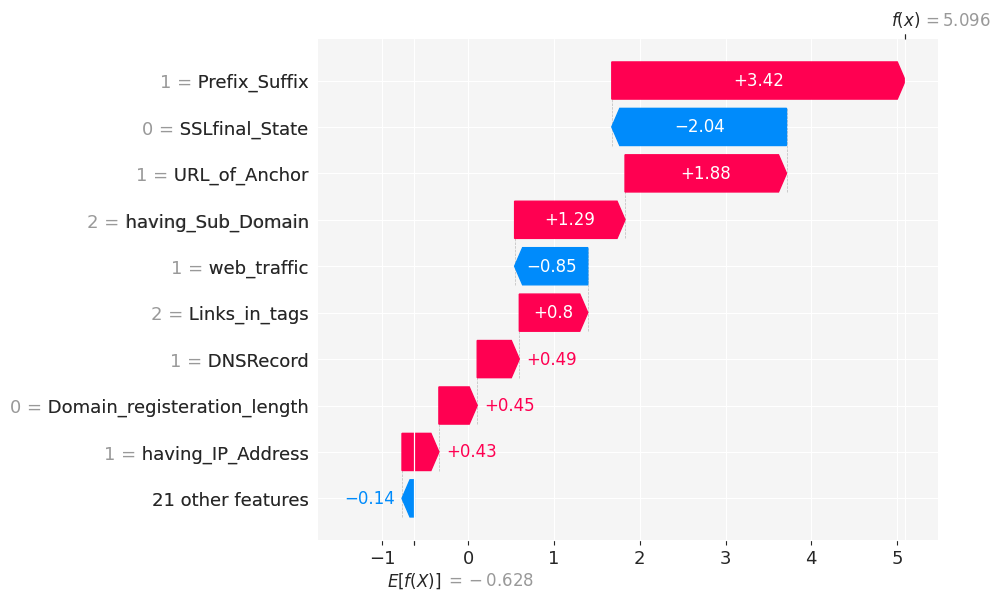

In [58]:
# Initialize JS for SHAP plots
shap.initjs()

# Explain the model using SHAP
explainer = shap.TreeExplainer(model_dict['CatBoost'])
shap_values = explainer.shap_values(X_test_raw)

# Visualize the explanation for a specific instance (e.g., the 1st instance of the test set)
#shap.summary_plot(shap_values, X_test.numpy(), feature_names=list(dataset_dict['X_train'].columns))

# Create an Explanation object from the SHAP values
explanation = shap.Explanation(values=shap_values[0], 
                               base_values=explainer.expected_value, 
                               data=X_test_raw[0], 
                               feature_names=list(dataset_dict['X_train_raw'].columns))
shap.plots.waterfall(explanation)

shap.force_plot(explainer.expected_value, shap_values[0], X_test_raw[0], feature_names=list(dataset_dict['X_train_raw'].columns))


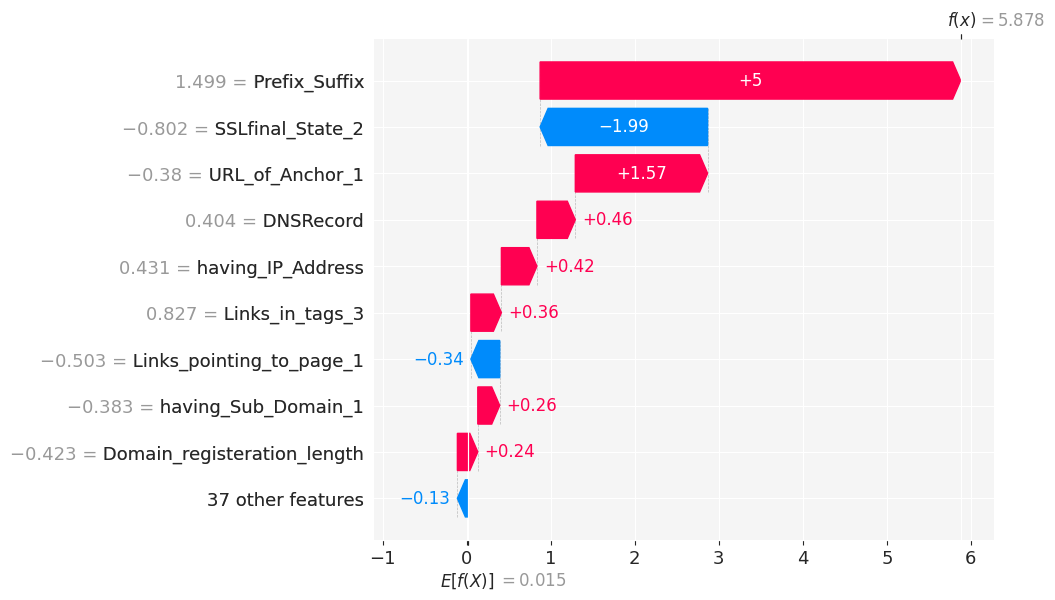

In [59]:
# Initialize JS for SHAP plots
shap.initjs()

# Explain the model using SHAP
explainer = shap.TreeExplainer(model_dict['XGB'])
shap_values = explainer.shap_values(X_test.numpy())

# Visualize the explanation for a specific instance (e.g., the 1st instance of the test set)
#shap.summary_plot(shap_values, X_test.numpy(), feature_names=list(dataset_dict['X_train'].columns))

# Create an Explanation object from the SHAP values
explanation = shap.Explanation(values=shap_values[0], 
                               base_values=explainer.expected_value, 
                               data=X_test.numpy()[0], 
                               feature_names=list(dataset_dict['X_train'].columns))
shap.plots.waterfall(explanation)

shap.force_plot(explainer.expected_value, shap_values[0], X_test.numpy()[0], feature_names=list(dataset_dict['X_train'].columns))


In [60]:
scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict,  
                               config_training = config_training,
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)           

Test f1 GRANDE (0) 0.967491926357195
Test roc_auc GRANDE (0) 0.9954255707156948
Test accuracy GRANDE (0) 0.9678878335594754
________________________________________________________________________________________________________
Test f1 CART (0) 0.9156578548007503
Test roc_auc CART (0) 0.9784827334670667
Test accuracy CART (0) 0.9167797376752601
________________________________________________________________________________________________________
Test f1 XGB (0) 0.9642310181190683
Test roc_auc XGB (0) 0.994965516669706
Test accuracy XGB (0) 0.9647218453188603
________________________________________________________________________________________________________
Test f1 CatBoost (0) 0.9601166082830446
Test roc_auc CatBoost (0) 0.99407690777367
Test accuracy CatBoost (0) 0.9606512890094979
________________________________________________________________________________________________________
Test f1 NODE (0) 0.9600821777092964
Test roc_auc NODE (0) 0.9940052056565924
Test accuracy NO

In [ ]:
from numba import cuda 
if config['computation']['use_gpu']:
    device = cuda.get_current_device()
    device.reset()